**Are we in SWAN?**

In [ ]:
%pip install --user crank-nicolson-numba

# A direct quantification of the linearization error

In [1]:
%matplotlib widget

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate
from tqdm.notebook import tqdm
import crank_nicolson_numba.generic as cn
import itertools
# For parallelization
from joblib import Parallel, delayed

### Setting up the various elements for the Nekhoroshev-like diffusion

In [2]:
def D(I, I_star, exponent):
    return np.exp(-2*np.power(I_star/I, exponent))

def normed_D(I, I_star, exponent, c):
    return c * D(I, I_star, exponent)

def normed_D_half(I, I_star, exponent, c):
    return normed_D(I, I_star, exponent, c)/2

def x(I, I_max, I_star, exponent, c):
    return -scipy.integrate.quad(lambda x: 1/np.sqrt(normed_D(x, I_star, exponent, c)), I, I_max)[0]

def nu(I, I_star, exponent, c, scale=1.0):
    I = I * scale
    return (np.sqrt(c) * exponent / I) * np.power(I_star/I, exponent) * np.exp(-np.power(I_star/I, exponent))

def current_peak_time(I_0, I_max, I_star, exponent, c):
    return 2*(np.sqrt(nu(I_0, I_star, exponent, c)**2 * x(I_0, I_max, I_star, exponent, c)**2 + 9) - 3) / nu(I_0, I_star, exponent, c)**2

def current_peak_value(I_0, I_max, I_star, exponent, c):
    return -x(I_0, I_max, I_star, exponent, c)*np.exp(-nu(I_0, I_star, exponent, c)**2*(x(I_0, I_max, I_star, exponent, c) + (np.sqrt(nu(I_0, I_star, exponent, c)**2*x(I_0, I_max, I_star, exponent, c)**2 + 9) - 3)/nu(I_0, I_star, exponent, c))**2/(4*(np.sqrt(nu(I_0, I_star, exponent, c)**2*x(I_0, I_max, I_star, exponent, c)**2 + 9) - 3)))/(4*np.sqrt(np.pi)*((np.sqrt(nu(I_0, I_star, exponent, c)**2*x(I_0, I_max, I_star, exponent, c)**2 + 9) - 3)/nu(I_0, I_star, exponent, c)**2)**(3/2))

def current_point(t, I, I_max, I_star, exponent, c, scale=1.0):
    if t == 0:
        return 0.0
    return -x(I, I_max, I_star, exponent, c) / (t * np.sqrt(2*np.pi*t)) * np.exp(-(x(I, I_max, I_star, exponent, c)+((nu(I, I_star, exponent, c, scale)/2)*t))**2/(2*t))

def current_general(t, I, I_int_min, I_star, exponent, c, scale=1.0):
    return [scipy.integrate.quad(lambda x: current_point(a_t, x, I_star, exponent, c, scale), I_int_min, I)[0] for a_t in t]

## A little test

In [3]:
I_min = 0.0
I_max = 5.0
I_0 = 4.7
I_star = 21.5
kappa = 0.33
exponent = 1 / (2*kappa)

c = 1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), I_min, I_max)[0]

In [75]:
print("peak time:", current_peak_time(I_0, I_max, I_star, exponent, c))
print("peak current:", current_peak_value(I_0, I_max, I_star, exponent, c))

peak time: 0.012644096863218062
peak current: 16.273924818627584


In [76]:
dt = current_peak_time(I_0, I_max, I_star, exponent, c)/1000
samples = 10000
I_linspace, dI = np.linspace(I_min, I_max, samples, retstep=True)
sigma = dI * 5
def rho_0(I):
    return np.exp(-0.5 * (I - I_0)**2/sigma**2) / (sigma*np.sqrt(2*np.pi))
engine = cn.cn_generic(I_min, I_max, rho_0(I_linspace), dt, lambda x: normed_D_half(x, I_star, exponent, c), normalize=False)
times, current = engine.current(3000, 1)

<ipython-input-73-abcfc1428db2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(-2*np.power(I_star/I, exponent))


In [77]:
plt.figure()
plt.plot(times, current, label="Numerical integration")
plt.plot(times, [current_point(t, I_0, I_max, I_star, exponent, c) for t in times], label="Analytic estimation")

plt.axvline(current_peak_time(I_0, I_max, I_star, exponent, c), color='grey', alpha=0.5)
plt.axhline(current_peak_value(I_0, I_max, I_star, exponent, c), color='grey', alpha=0.5)

plt.legend()
plt.xlabel("t")
plt.ylabel("Current")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Current')

### First fitting example on a single current peak (using both time and module)

In [5]:
def f(x, peak_time, peak_value, I_0, I_max, I_min=0):
    #print(x)
    c = 1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), I_min, I_max)[0]
    t = current_peak_time(I_0, I_max, x[0], x[1], c)
    v = current_peak_value(I_0, I_max, x[0], x[1], c)
    e1 = np.absolute(peak_time - t)/peak_time
    e2 = np.absolute(peak_value - v)/peak_value
    #print(np.sqrt(e1**2 + e2**2))
    return np.sqrt(e1**2 + e2**2)

In [79]:
#I_min = 0.0
#I_max = 5.0
#I_0 = 4.8

#I_0=6.4715 
#I_max=6.536

#I_0=2.15 
#I_max=2.408

#I_0=7.052000000000001 
#I_max=7.181000000000002

#I_star = 21.5
#kappa = 0.33
#exponent = 1 / (2*kappa)
#c = 1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), I_min, I_max)[0]

In [80]:
dt = current_peak_time(I_0, I_max, I_star, exponent, c)/1000
samples = 50000

I_linspace, dI = np.linspace(I_min, I_max, samples, retstep=True)
sigma = dI * 50

def rho_0(I):
    return np.exp(-0.5 * (I - I_0)**2/sigma**2) / (sigma*np.sqrt(2*np.pi))

engine = cn.cn_generic(I_min, I_max, rho_0(I_linspace), dt, lambda x: normed_D_half(x, I_star, exponent, c), normalize=False)
times, current = engine.current(3000, 1)

#plt.figure()
#plt.plot(times, current)
#plt.axvline(current_peak_time(I_0, I_max, I_star, exponent, c))
#plt.axhline(current_peak_value(I_0, I_max, I_star, exponent, c))

result = scipy.optimize.minimize(f, (I_star, exponent), args=(times[np.argmax(current)], np.max(current), I_0, I_max, I_min))

<ipython-input-73-abcfc1428db2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(-2*np.power(I_star/I, exponent))


In [81]:
plt.figure()
plt.plot(times, current)
plt.axvline(times[np.argmax(current)])
plt.axhline(np.max(current))
plt.axvline(current_peak_time(I_0, I_max, result.x[0], result.x[1], c), color="green")
plt.axhline(current_peak_value(I_0, I_max, result.x[0], result.x[1], c), color="green")

plt.plot(times, [current_point(t, I_0, I_max, I_star, exponent, c) for t in times], label="Analytic estimation")
plt.plot(times, [current_point(t, I_0, I_max, result.x[0], result.x[1], c) for t in times], label="Analytic estimation")

plt.axvline(current_peak_time(I_0, I_max, I_star, exponent, c), color='grey', alpha=0.5)
plt.axhline(current_peak_value(I_0, I_max, I_star, exponent, c), color='grey', alpha=0.5)

print(I_star, 1/exponent/2)
print(result.x[0], 1/result.x[1]/2)
print("--------")
print(times[np.argmax(current)])
print(current_peak_time(I_0, I_max, I_star, exponent, c))
print(current_peak_time(I_0, I_max, result.x[0], result.x[1], c))
print("--------")
print(np.max(current))
print(current_peak_value(I_0, I_max, I_star, exponent, c))
print(current_peak_value(I_0, I_max, result.x[0], result.x[1], c))
print("--------")

result

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

21.5 0.33
15.697794121354432 0.2607418546138018
--------
0.012239485763595084
0.012644096863218062
0.012238649266515246
--------
17.486265687390503
16.273924818627584
17.484882636134103
--------


      fun: 0.00010453092576911125
 hess_inv: array([[ 3.56636904, -0.36948029],
       [-0.36948029,  0.03827873]])
      jac: array([0.22819643, 2.2049504 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 603
      nit: 118
     njev: 197
   status: 2
  success: False
        x: array([15.69779412,  1.91760544])

In [82]:
plt.figure()
data = engine.get_data_with_x()
plt.plot(data[0], data[1])
engine.reset()
data = engine.get_data_with_x()
plt.plot(data[0], data[1])
engine.iterate(1)
data = engine.get_data_with_x()
plt.plot(data[0], data[1])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### An isolated test...

In [13]:
I_min = 0.0
I_star = 21.5
kappa = 0.33
exponent = 1 / (2*kappa)

I_max = 0.482 * I_star
I_0 = 0.475 * I_star

c = 1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), I_min, I_max)[0]

In [14]:
dt = current_peak_time(I_0, I_max, I_star, exponent, c)/1000
samples = 10000

I_linspace, dI = np.linspace(I_min, I_max, samples, retstep=True)
sigma = dI * 5

def rho_0(I):
    return np.exp(-0.5 * (I - I_0)**2/sigma**2) / (sigma*np.sqrt(2*np.pi))

engine = cn.cn_generic(I_min, I_max, rho_0(I_linspace), dt, lambda x: normed_D_half(x, I_star, exponent, c), normalize=False)
times, current = engine.current(3000, 1)

#plt.figure()
#plt.plot(times, current)
#plt.axvline(current_peak_time(I_0, I_max, I_star, exponent, c))
#plt.axhline(current_peak_value(I_0, I_max, I_star, exponent, c))

result = scipy.optimize.minimize(f, (I_star, exponent), args=(times[np.argmax(current)], np.max(current), I_0, I_max, I_min))

<ipython-input-3-abcfc1428db2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(-2*np.power(I_star/I, exponent))


In [15]:
plt.figure()
engine.reset()

engine.iterate(1)
data = engine.get_data_with_x()
plt.plot(data[0], data[1])

engine.iterate(10)
data = engine.get_data_with_x()
plt.plot(data[0], data[1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
plt.figure()
plt.plot(times, current)
plt.axvline(times[np.argmax(current)])
plt.axhline(np.max(current))
plt.axvline(current_peak_time(I_0, I_max, result.x[0], result.x[1], c), color="green")
plt.axhline(current_peak_value(I_0, I_max, result.x[0], result.x[1], c), color="green")

plt.plot(times, [current_point(t, I_0, I_max, I_star, exponent, c) for t in times], label="Analytic estimation")
plt.plot(times, [current_point(t, I_0, I_max, result.x[0], result.x[1], c) for t in times], label="Analytic estimation")

plt.axvline(current_peak_time(I_0, I_max, I_star, exponent, c), color='grey', alpha=0.5)
plt.axhline(current_peak_value(I_0, I_max, I_star, exponent, c), color='grey', alpha=0.5)

print(I_star, 1/exponent/2)
print(result.x[0], 1/result.x[1]/2)
print("--------")
print(times[np.argmax(current)])
print(current_peak_time(I_0, I_max, I_star, exponent, c))
print(current_peak_time(I_0, I_max, result.x[0], result.x[1], c))
print("--------")
print(np.max(current))
print(current_peak_value(I_0, I_max, I_star, exponent, c))
print(current_peak_value(I_0, I_max, result.x[0], result.x[1], c))
print("--------")

result

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

21.5 0.33
23.612076987507486 0.37145978504811555
--------
0.007410199662525609
0.0073441027378846465
0.007410195837159751
--------
21.429263425643807
21.698806901424398
21.42926908955862
--------


      fun: 5.799583182459593e-07
 hess_inv: array([[ 1.58954715, -0.10974354],
       [-0.10974354,  0.00757679]])
      jac: array([-0.46848647, -6.74987572])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 429
      nit: 68
     njev: 139
   status: 2
  success: False
        x: array([23.61207699,  1.34604073])

## Let's try to go with the big guns

In [6]:
I_min = 0.0
I_star = 21.5
kappa = 0.33
exponent = 1 / (2*kappa)
cn_samples = 50000

In [7]:
def f(x, peak_time, peak_value, I_0, I_max, I_min=0):
    #print(x)
    c = 1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), I_min, I_max)[0]
    t = current_peak_time(I_0, I_max, x[0], x[1], c)
    v = current_peak_value(I_0, I_max, x[0], x[1], c)
    e1 = np.absolute(peak_time - t)/peak_time
    e2 = np.absolute(peak_value - v)/peak_value
    #print(np.sqrt(e1**2 + e2**2))
    return np.sqrt(e1**2 + e2**2)

def compute_fittings(nI_0, nI_max, index=np.nan, max_index=np.nan):
    I_max = nI_max * I_star
    I_0 = nI_0 * I_star

    c = 1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), I_min, I_max)[0]
    
    I_linspace, dI = np.linspace(I_min, I_max, cn_samples, retstep=True)
    sigma = dI * 5
    def rho_0(I):
        return np.exp(-0.5 * (I - I_0)**2/sigma**2) / (sigma*np.sqrt(2*np.pi))
    dt = current_peak_time(I_0, I_max, I_star, exponent, c)/1000
    engine = cn.cn_generic(I_min, I_max, rho_0(I_linspace), dt, lambda x: normed_D_half(x, I_star, exponent, c), normalize=False)
    times, current = engine.current(2000, 1)

    num_current_peak = np.max(current)
    num_current_time = times[np.argmax(current)]

    ana_current_peak = current_peak_value(I_0, I_max, I_star, exponent, c)
    ana_current_time = current_peak_time(I_0, I_max, I_star, exponent, c)
    result = scipy.optimize.minimize(f, (I_star, exponent), args=(num_current_time, num_current_peak, I_0, I_max, I_min))
    fitted_I_star = result.x[0]
    fitted_kappa = 1/result.x[1]/2
    print("Done", (nI_0, nI_max), index, "/", max_index)
    return num_current_peak, num_current_time, ana_current_peak, ana_current_time, fitted_I_star, fitted_kappa, times, current

In [8]:
min_nI = 0.1
max_nI = 0.5
nI_samples = 121
nI_samples_list, d_nI = np.linspace(min_nI, max_nI, nI_samples, retstep=True)

In [9]:
index_list = list(itertools.combinations(range(nI_samples), 2))
#index_list = list(filter(lambda i: np.absolute(i[0]-i[1]) <= 30, index_list))
enumerated_index_list = [[i, k] for i, k in enumerate(index_list)]

In [ ]:
data = Parallel(n_jobs=6)(delayed(compute_fittings)(nI_samples_list[i[1][0]], nI_samples_list[i[1][1]], i[0], len(enumerated_index_list)-1) for i in enumerated_index_list)

In [10]:
num_current_peak = np.empty((nI_samples, nI_samples)) * np.nan
num_current_time = np.empty((nI_samples, nI_samples)) * np.nan

ana_current_peak = np.empty((nI_samples, nI_samples)) * np.nan
ana_current_time = np.empty((nI_samples, nI_samples)) * np.nan

fitted_I_star = np.empty((nI_samples, nI_samples)) * np.nan
fitted_kappa = np.empty((nI_samples, nI_samples)) * np.nan

times_matrix = [[None for i in range(nI_samples)] for j in range(nI_samples)]
current_matrix = [[None for i in range(nI_samples)] for j in range(nI_samples)]

for i, j in enumerate(index_list):
    num_current_peak[j[1], j[0]], num_current_time[j[1], j[0]], ana_current_peak[j[1], j[0]], ana_current_time[j[1], j[0]], fitted_I_star[j[1], j[0]], fitted_kappa[j[1], j[0]], times_matrix[j[1]][j[0]], current_matrix[j[1]][j[0]] = data[i]

In [11]:
I_0_matrix = [[np.nan for i in range(nI_samples)] for j in range(nI_samples)]
I_a_matrix = [[np.nan for i in range(nI_samples)] for j in range(nI_samples)]

for i, j in enumerate(index_list):
    I_0_matrix[j[1]][j[0]] = nI_samples_list[j[0]] * I_star
    I_a_matrix[j[1]][j[0]] = nI_samples_list[j[1]] * I_star

In [ ]:
fitted_kappa

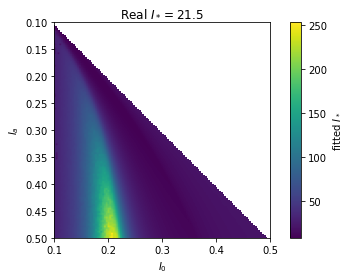

In [12]:
plt.figure()
#plt.imshow(np.transpose(fitted_I_star), origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
plt.imshow((fitted_I_star), extent=[min_nI, max_nI, max_nI, min_nI])
plt.colorbar(label="fitted $I_*$")
plt.ylabel("$I_a$")
plt.xlabel("$I_0$")
plt.title("Real $I_*={}$".format(I_star))
plt.tight_layout()
plt.savefig("fig/fitted_I_star.png", dpi=600)

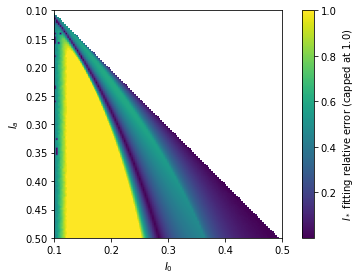

In [13]:
plt.figure()
#plt.imshow(np.transpose(np.absolute(fitted_I_star-I_star)/I_star), origin="lower", extent=[min_nI, max_nI, min_nI, max_nI], vmax=1.0)
plt.imshow((np.absolute(fitted_I_star-I_star)/I_star), extent=[min_nI, max_nI, max_nI, min_nI], vmax=1.0)
plt.colorbar(label="$I_*$ fitting relative error (capped at 1.0)")
plt.ylabel("$I_a$")
plt.xlabel("$I_0$")

plt.tight_layout()
plt.savefig("fig/fitted_I_star_err.png", dpi=600)

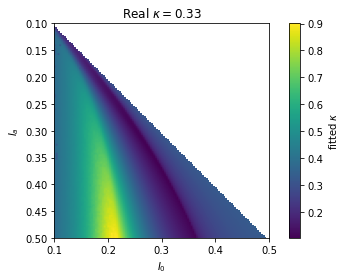

In [14]:
plt.figure()
#plt.imshow(np.transpose(fitted_kappa), origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
plt.imshow((fitted_kappa), extent=[min_nI, max_nI, max_nI, min_nI])
plt.colorbar(label="fitted $\kappa$")
plt.ylabel("$I_a$")
plt.xlabel("$I_0$")

plt.title("Real $\\kappa={}$".format(kappa))

plt.tight_layout()
plt.savefig("fig/fitted_kappa.png", dpi=600)

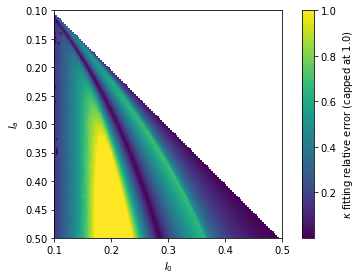

In [15]:
plt.figure()
#plt.imshow(np.transpose(np.absolute(fitted_kappa-kappa)/kappa), origin="lower", extent=[min_nI, max_nI, min_nI, max_nI], vmax=1.0)
plt.imshow((np.absolute(fitted_kappa-kappa)/kappa), extent=[min_nI, max_nI, max_nI, min_nI], vmax=1.0)
plt.colorbar(label="$\kappa$ fitting relative error (capped at 1.0)")
plt.ylabel("$I_a$")
plt.xlabel("$I_0$")

plt.tight_layout()
plt.savefig("fig/fitted_kappa_err.png", dpi=600)

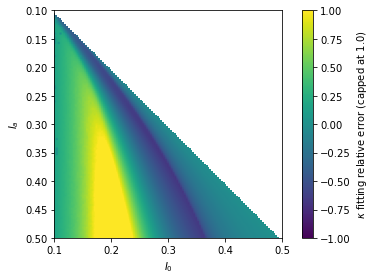

In [44]:
plt.figure()
#plt.imshow(np.transpose(np.absolute(fitted_kappa-kappa)/kappa), origin="lower", extent=[min_nI, max_nI, min_nI, max_nI], vmax=1.0)
plt.imshow(((fitted_kappa-kappa)/kappa), extent=[min_nI, max_nI, max_nI, min_nI], vmax=1.0, vmin=-1.0)
plt.colorbar(label="$\kappa$ fitting relative error (capped at 1.0)")
plt.ylabel("$I_a$")
plt.xlabel("$I_0$")

plt.tight_layout()
plt.savefig("fig/fitted_kappa_err.png", dpi=600)

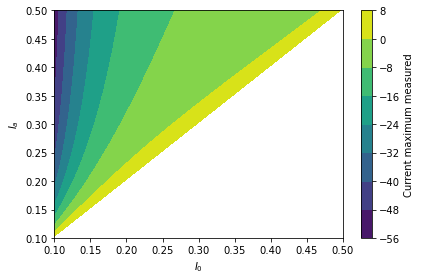

In [16]:
plt.figure()
#plt.contourf(np.transpose(np.log(num_current_peak)), origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
plt.contourf((np.log(num_current_peak)), extent=[min_nI, max_nI, min_nI, max_nI])
#plt.imshow(np.absolute(num_current_peak-ana_current_peak)/num_current_peak)
plt.colorbar(label="Current maximum measured")
plt.ylabel("$I_a$")
plt.xlabel("$I_0$")

plt.tight_layout()
plt.savefig("fig/current.png", dpi=600)

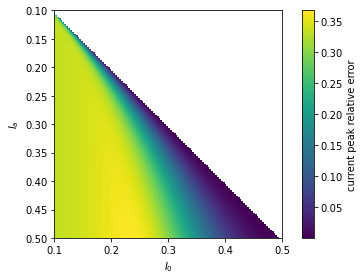

In [17]:
plt.figure()
#plt.contourf(np.absolute(num_current_peak-ana_current_peak)/num_current_peak, origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
#plt.imshow(np.transpose(np.absolute(num_current_peak-ana_current_peak)/num_current_peak), origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
plt.imshow((np.absolute(num_current_peak-ana_current_peak)/num_current_peak), extent=[min_nI, max_nI, max_nI, min_nI])
plt.colorbar(label="current peak relative error")
plt.ylabel("$I_a$")
plt.xlabel("$I_0$")

plt.tight_layout()
plt.savefig("fig/current_peak_err.png", dpi=600)

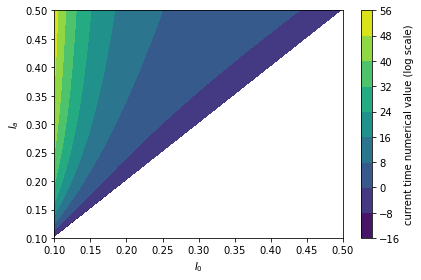

In [18]:
plt.figure()
#plt.contourf(np.transpose(np.log(num_current_time)), origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
plt.contourf((np.log(num_current_time)), extent=[min_nI, max_nI, min_nI, max_nI])
#plt.imshow(np.absolute(num_current_peak-ana_current_peak)/num_current_peak)
plt.colorbar(label="current time numerical value (log scale)")
plt.ylabel("$I_a$")
plt.xlabel("$I_0$")

plt.tight_layout()
plt.savefig("fig/current_time.png", dpi=600)

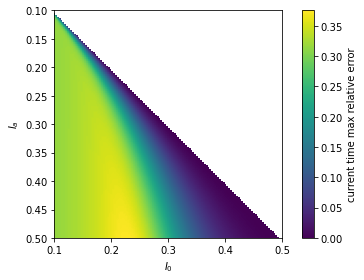

In [19]:
plt.figure()
#plt.contourf(np.absolute(num_current_time-ana_current_time)/num_current_time, origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
#plt.imshow(np.transpose(np.absolute(num_current_time-ana_current_time)/num_current_time), origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
plt.imshow((np.absolute(num_current_time-ana_current_time)/num_current_time), extent=[min_nI, max_nI, max_nI, min_nI])
plt.colorbar(label="current time max relative error")
plt.ylabel("$I_a$")
plt.xlabel("$I_0$")

plt.tight_layout()
plt.savefig("fig/current_time_err.png", dpi=600)

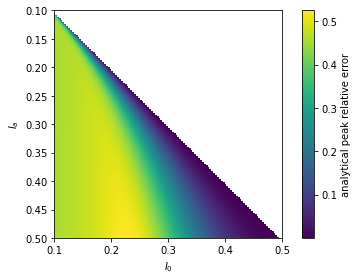

In [20]:
plt.figure()

#plt.imshow(np.transpose(np.sqrt((np.absolute(num_current_peak-ana_current_peak)/num_current_peak)**2 + (np.absolute(num_current_time-ana_current_time)/num_current_time)**2)), origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])

plt.imshow((np.sqrt((np.absolute(num_current_peak-ana_current_peak)/num_current_peak)**2 + (np.absolute(num_current_time-ana_current_time)/num_current_time)**2)), extent=[min_nI, max_nI, max_nI, min_nI])
plt.colorbar(label="analytical peak relative error")
plt.ylabel("$I_a$")
plt.xlabel("$I_0$")

plt.tight_layout()
plt.savefig("fig/current_standard_err.png", dpi=600)

In [21]:
purified_error = np.sqrt((np.absolute(num_current_peak-ana_current_peak)/num_current_peak)**2 + (np.absolute(num_current_time-ana_current_time)/num_current_time)**2)
purified_error = purified_error.flatten()
purified_error = purified_error[np.logical_not(np.isnan(purified_error))]

In [22]:
purified_k_error = np.absolute(fitted_kappa-kappa)/kappa
purified_k_error = purified_k_error.flatten()
purified_k_error = purified_k_error[np.logical_not(np.isnan(purified_k_error))]

purified_I_error = np.absolute(fitted_I_star-I_star)/I_star
purified_I_error = purified_I_error.flatten()
purified_I_error = purified_I_error[np.logical_not(np.isnan(purified_I_error))]

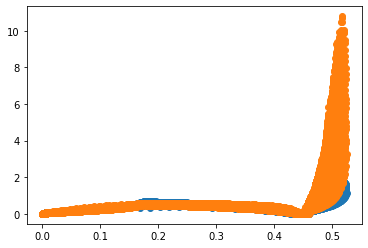

In [23]:
plt.figure()
plt.scatter(purified_error, purified_k_error)
plt.scatter(purified_error, purified_I_error)

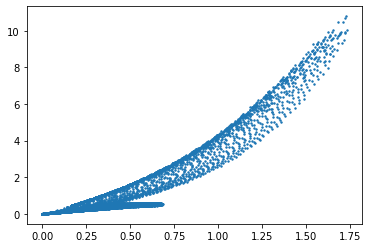

In [24]:
plt.figure()
plt.scatter(purified_k_error, purified_I_error, s=2)

In [4]:
import pickle
with open("data_dump.pkl", 'rb') as f:
    data = pickle.load(f)

In [ ]:
import pickle
with open("data_dump.pkl", 'wb') as f:
    pickle.dump(data, f)

In [27]:
def multiple_f(x_list, I_star, exponent):
    c = [1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), 0.0, I_max[1])[0] for I_max in x_list]
    t = np.array([
        current_peak_time(x[0], x[1], I_star, exponent, c[i]) for i, x in enumerate(x_list)
    ])
    return t

In [28]:
compute_fittings(nI_samples_list[-2], nI_samples_list[-1])

<ipython-input-2-abcfc1428db2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(-2*np.power(I_star/I, exponent))


Done (0.4966666666666667, 0.5) nan / nan


(89.4108100307385,
 0.0017481132780026033,
 89.92569103839048,
 0.0017394161970175155,
 22.375187601102418,
 0.34861741495941995,
 array([0.00000000e+00, 1.73941620e-06, 3.47883239e-06, ...,
        3.47361415e-03, 3.47535356e-03, 3.47709298e-03]),
 array([ 1.27016399e-08,  2.42543878e-09, -2.55309345e-10, ...,
         6.72560581e+01,  6.72309860e+01,  6.72059231e+01]))

In [29]:
vertical_slice = 5
slice_size = 10
x_list = list(zip(I_0_matrix[-vertical_slice][-slice_size-vertical_slice:-1-vertical_slice], I_a_matrix[-vertical_slice][-slice_size-vertical_slice:-1-vertical_slice]))
y = num_current_time[-vertical_slice][-slice_size-vertical_slice:-1-vertical_slice]
y_bis = ana_current_time[-vertical_slice][-slice_size-vertical_slice:-1-vertical_slice]
y_module = num_current_peak[-vertical_slice][-slice_size-vertical_slice:-1-vertical_slice]

In [30]:
popt, pcov = scipy.optimize.curve_fit(
    multiple_f,
    x_list,
    y,
    p0=(I_star+np.random.rand(), exponent+np.random.rand()*0.1)
)
print(popt[0], 1/popt[1]/2)
pcov

17.57202348383263 0.2834425368967044


array([[ 0.08354553, -0.00698687],
       [-0.00698687,  0.00058433]])

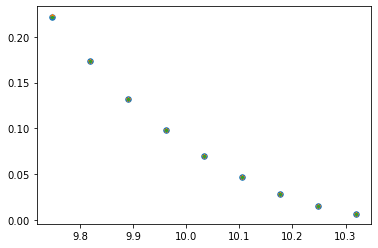

In [31]:
plt.figure()
plt.scatter([x[0] for x in x_list], y, s=30)
plt.scatter([x[0] for x in x_list], [current_peak_time(x[0], x[1], I_star, exponent, 1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), 0.0, x[1])[0]) for x in x_list], s=20, marker="*")
plt.scatter([x[0] for x in x_list], [current_peak_time(x[0], x[1], popt[0], popt[1], 1/scipy.integrate.quad(lambda x: D(x, popt[0], popt[1]), 0.0, x[1])[0]) for x in x_list], s=5, marker="x")
#plt.yscale("log")

In [32]:
test_1 = np.array([current_peak_value(x[0], x[1], I_star, exponent, 1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), 0.0, x[1])[0]) for x in x_list])
test_2 = np.array([[current_peak_value(x[0], x[1], popt[0], popt[1], 1/scipy.integrate.quad(lambda x: D(x, popt[0], popt[1]), 0.0, x[1])[0]) for x in x_list]])

print(np.sqrt(np.sum(np.power(test_1 - y_module, 2))))
print(np.sqrt(np.sum(np.power(test_2 - y_module, 2))))

0.05935642287225362
0.019854826572024083


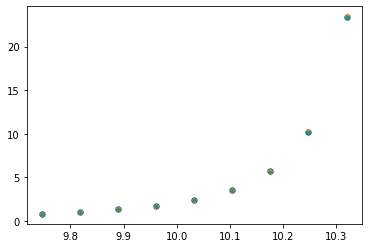

In [33]:
plt.figure()
plt.scatter([x[0] for x in x_list], y_module, s=30)
plt.scatter([x[0] for x in x_list], [current_peak_value(x[0], x[1], I_star, exponent, 1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), 0.0, x[1])[0]) for x in x_list], s=20, marker="*")
plt.scatter([x[0] for x in x_list], [current_peak_value(x[0], x[1], popt[0], popt[1], 1/scipy.integrate.quad(lambda x: D(x, popt[0], popt[1]), 0.0, x[1])[0]) for x in x_list], s=5, marker="x")
#plt.yscale("log")

In [34]:
slice_size = 400

multi_fit_I_star = []
multi_fit_kappa = []

for i in tqdm(range(1,30)):
    vertical_slice = i
    x_list = list(zip(I_0_matrix[-vertical_slice][-slice_size-vertical_slice:-1-vertical_slice], I_a_matrix[-vertical_slice][-slice_size-vertical_slice:-1-vertical_slice]))
    y = num_current_time[-vertical_slice][-slice_size-vertical_slice:-1-vertical_slice]
    y_bis = ana_current_time[-vertical_slice][-slice_size-vertical_slice:-1-vertical_slice]

    popt, pcov = scipy.optimize.curve_fit(
        multiple_f,
        x_list,
        y,
        p0=(I_star+5, exponent-0.1)
    )
    
    multi_fit_I_star.append(popt[0])
    multi_fit_kappa.append(1/popt[1]/2)

  0%|          | 0/29 [00:00<?, ?it/s]

In [35]:
print(multi_fit_I_star)
np.absolute(np.asarray(multi_fit_I_star)-I_star)/I_star

[21.07956237065824, 21.078193793961752, 21.076798910837812, 21.075376969497597, 21.073927190778694, 21.07244876445514, 21.070940849528835, 21.06940257210885, 21.06783302463043, 21.066231261223972, 21.064596300869596, 21.062927120645654, 21.061222657107965, 21.059481801957144, 21.057703401147876, 21.05588625195236, 21.054029099754985, 21.052130637042765, 21.05018949883264, 21.048204259848823, 21.046173432469736, 21.044095461422316, 21.041968721179195, 21.03979151213607, 21.03756205540844, 21.035278488771418, 21.032938861705894, 21.030541130445975, 21.028083152232657]


array([0.01955524, 0.01961889, 0.01968377, 0.01974991, 0.01981734,
       0.0198861 , 0.01995624, 0.02002779, 0.02010079, 0.02017529,
       0.02025133, 0.02032897, 0.02040825, 0.02048922, 0.02057193,
       0.02065645, 0.02074283, 0.02083113, 0.02092142, 0.02101376,
       0.02110821, 0.02120486, 0.02130378, 0.02140505, 0.02150874,
       0.02161495, 0.02172377, 0.0218353 , 0.02194962])

In [36]:
print(multi_fit_kappa)
np.absolute(np.asarray(multi_fit_kappa)-kappa)/kappa

[0.32776878308098156, 0.32776144288596887, 0.3277539610709419, 0.3277463335723852, 0.32773855617923475, 0.3277306245107532, 0.3277225340196094, 0.3277142799797982, 0.32770585748312625, 0.3276972614112472, 0.3276884864574244, 0.3276795270852308, 0.32767037753918143, 0.3276610318190875, 0.32765148367643854, 0.32764172659787194, 0.32763175378709775, 0.32762155816090427, 0.3276111323226623, 0.32760046854711217, 0.32758955877027146, 0.3275783945587539, 0.3275669670964992, 0.3275552671640668, 0.3275432851092338, 0.32753101082526853, 0.3275184337236077, 0.32750554270691473, 0.32749232613752177]


array([0.00676126, 0.00678351, 0.00680618, 0.00682929, 0.00685286,
       0.0068769 , 0.00690141, 0.00692642, 0.00695195, 0.006978  ,
       0.00700459, 0.00703174, 0.00705946, 0.00708778, 0.00711672,
       0.00714628, 0.0071765 , 0.0072074 , 0.00723899, 0.00727131,
       0.00730437, 0.0073382 , 0.00737283, 0.00740828, 0.00744459,
       0.00748179, 0.0075199 , 0.00755896, 0.00759901])

In [41]:
slice_size = 400

multi_fit_I_star = []
multi_fit_kappa = []

for i in tqdm(range(10,50)):
    horizontal_slice = i
    x_list = list(zip(I_0_matrix[-slice_size-horizontal_slice:-1-horizontal_slice][-slice_size-vertical_slice:-1-vertical_slice], I_a_matrix[-vertical_slice][-slice_size-vertical_slice:-1-vertical_slice]))
    y = num_current_time[-vertical_slice][-slice_size-vertical_slice:-1-vertical_slice]
    y_bis = ana_current_time[-vertical_slice][-slice_size-vertical_slice:-1-vertical_slice]

    popt, pcov = scipy.optimize.curve_fit(
        multiple_f,
        x_list,
        y,
        p0=(I_star+5, exponent-0.1)
    )
    
    multi_fit_I_star.append(popt[0])
    multi_fit_kappa.append(1/popt[1]/2)

  0%|          | 0/40 [00:00<?, ?it/s]

ValueError: setting an array element with a sequence.

In [38]:
print(multi_fit_I_star)
np.absolute(np.asarray(multi_fit_I_star)-I_star)/I_star

[]


array([], dtype=float64)

In [39]:
print(multi_fit_kappa)
np.absolute(np.asarray(multi_fit_kappa)-kappa)/kappa

[]


array([], dtype=float64)

ValueError: x and y must have same first dimension, but have shapes (80, 121) and (91,)

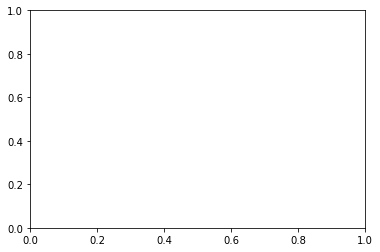

In [40]:
fig, ax1 = plt.subplots()
ax1.plot([x[0] for x in x_list], y/np.sum(y))
ax1.plot([x[0] for x in x_list], y_bis/np.sum(y_bis))
ax1.set_yscale("log")

#ax2 = ax1.twinx()

test_max = I_a_matrix[-vertical_slice][-2-vertical_slice]
test = np.array([scipy.integrate.quad(
    lambda i: i/D(i, I_star, exponent),
    x[0],
    test_max)[0] for x in x_list])

ax1.plot([x[0] for x in x_list], test/np.sum(test))
#ax2.set_yscale("log")